# Shadow cast

__ray tracing, rt programs__

In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav
    !pip install git+https://github.com/rendervous/vulky_project.git
except:
    print("Executing locally")

Executing locally


In [2]:
import vulky as vk
import vulky.datasets as datasets
import numpy as np

vk.create_device(debug=True)

SCREEN_WIDTH = 512
SCREEN_HEIGHT = 512

render_target = vk.image_2D(
    image_format=vk.Format.VEC4,
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT,
    mips=1,  # Important to make the image single resource
    usage=vk.ImageUsage.STORAGE,
    memory=vk.MemoryLocation.GPU
)

data = datasets.Meshes.bunny
# data = vk.load_obj('./vulky_data/bunny.obj')
vertices_data, indices_data = vk.create_mesh(data, mode='po')

triangles_vb = vk.structured_buffer(
    count=len(vertices_data), 
    element_description=dict(
        P=vk.vec3,
        N=vk.vec3,
        C=vk.vec2
    ),
    usage=vk.BufferUsage.RAYTRACING_RESOURCE    
).load(vertices_data)
triangles_ib = vk.structured_buffer(
    count=indices_data.numel(),
    element_description=int,
    usage=vk.BufferUsage.RAYTRACING_RESOURCE
).load(indices_data)

triangles = vk.triangle_collection()
triangles.append(triangles_vb, triangles_ib)
geometry_ads = vk.ads_model(triangles)

instance_transforms = vk.tensor(3, 4, 3)
for i in range(3):
    instance_transforms[i] = vk.mat4x3.trs(vk.vec3(np.cos(i * 6.28 / 3), -0.2, np.sin(i * 6.28 / 3)), vk.vec3(0., 1., 0.0), i*3.14159/3, vk.vec3.one())
 
instances = vk.instance_buffer(3)
with instances.map(mode='inout') as m:
    m.accelerationStructureReference = geometry_ads.handle
    m.transform = vk.mat4x3(instance_transforms).transposed()
    
scene_ads = vk.ads_scene(instances)    

scratch_buffer = vk.scratch_buffer(geometry_ads, scene_ads)
    
with vk.raytracing_manager() as man:
    man.build_ads(geometry_ads, scratch_buffer)
    man.build_ads(scene_ads, scratch_buffer)
    
global_transform = vk.object_buffer(
    vk.Layout.from_structure(
        vk.LayoutAlignment.SCALAR,
        Proj=vk.mat4,
        View=vk.mat4,
        LightPos=vk.vec3
    )
)

with global_transform as b:
    b.Proj = vk.mat4.perspective()
    b.View = vk.mat4.look_at(vk.vec3(0., 1., 4.), vk.vec3(0., 0.5, 0.), vk.vec3(0.,1., 0.))
    b.LightPos = vk.vec3(1, 5, 2)

[INFO] Debug instance created...
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserted device layer "VK_LAYER_NV_optimus" (C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll)
[PRINT] vkCreateDevice layer callstack setup to:
[PRINT]    <Application>
[PRINT]      ||
[PRINT]    <Loader>
[PRINT]      ||
[PRINT]    VK_LAYER_NV_optimus
[PRINT]            Type: Implicit
[PRINT]                Disable Env Var:  DISABLE_LAYER_NV_OPTIMUS_1
[PRINT]            Manifest: C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\nv-vk64.json
[PRINT]            Library:  C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll
[PRINT]      ||
[PRINT]    VK_LAYER_OBS_HOOK
[PRINT]            Type: Implici

In [3]:
ray_generation_shader_code = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(set = 0, binding = 0) uniform accelerationStructureEXT Scene;
layout(set = 0, binding = 1) uniform Globals {
    mat4 proj;
    mat4 view;
    vec3 light_dir;
} globals;
layout(set = 0, binding = 2, rgba32f) uniform image2D ResultImage;

layout(location = 0) rayPayloadEXT vec4 ResultColor;

void main() {
    vec2 uv = (gl_LaunchIDEXT.xy + vec2(0.5)) / vec2(gl_LaunchSizeEXT.xy);
    vec4 P = vec4(uv.x * 2 - 1.0, 1.0 - uv.y * 2, 0.0, 1.0);
    vec4 T = vec4(uv.x * 2 - 1.0, 1.0 - uv.y * 2, 1.0, 1.0);
    mat4 inv_transform = inverse(globals.proj * globals.view); 
    P = inv_transform * P;
    T = inv_transform * T;
    vec3 o = P.xyz / P.w;
    vec3 d = normalize(T.xyz/T.w - o);
    traceRayEXT(Scene, gl_RayFlagsNoneEXT, 0xFF, 0, 0, 0, o, 0.001, d, 1000.0f, 0);
    imageStore(ResultImage, ivec2(gl_LaunchIDEXT.xy), ResultColor);
}  
"""
closest_hit_shader_code = """
#version 460
#extension GL_EXT_ray_tracing : require
#extension GL_EXT_scalar_block_layout : require

layout(set = 0, binding = 0) uniform accelerationStructureEXT Scene;
layout(set = 0, binding = 1) uniform Globals {
    mat4 proj;
    mat4 view;
    vec3 light_pos;
} globals;

layout(location = 0) rayPayloadInEXT vec4 ResultColor;
layout(location = 1) rayPayloadInEXT float shadowCast;

hitAttributeEXT vec2 HitAttribs;

struct Vertex {
    vec3 P;
    vec3 N;
    vec2 C;
};

layout(scalar, set=0, binding = 3) readonly buffer Vertices {
    Vertex data[];
} vertices;

layout(scalar, set=0, binding = 4) readonly buffer Indices {
    int data[];
} indices;

void main() {
    int triangleIndex = gl_PrimitiveID;
    Vertex v0 = vertices.data[indices.data[triangleIndex*3 + 0]];
    Vertex v1 = vertices.data[indices.data[triangleIndex*3 + 1]];
    Vertex v2 = vertices.data[indices.data[triangleIndex*3 + 2]];
    vec3 coord = vec3(1 - HitAttribs.x - HitAttribs.y, HitAttribs.x, HitAttribs.y);
    vec3 P = v0.P * coord.x + v1.P * coord.y + v2.P * coord.z;
    P = gl_ObjectToWorldEXT * vec4(P, 1);
    vec3 N = v0.N * coord.x + v1.N * coord.y + v2.N * coord.z;
    N = normalize(gl_ObjectToWorldEXT * vec4(N, 0));
    vec3 Lp = globals.light_pos;
    float d = length(Lp - P);
    vec3 L = (Lp - P)/d;
    traceRayEXT(Scene,  // Cast shadows
        gl_RayFlagsTerminateOnFirstHitEXT, // cause any cast shadows 
        0xFF, 
        1,  // st offset
        0,  // st stride
        1,  // st miss idx
        P + N * 0.0001, 
        0.001, 
        L, 
        1000.0f, 
        1);
    vec3 V = -gl_WorldRayDirectionEXT;
    vec3 light_intensity = vec3(100);
    vec3 albedo = vec3(1, 1, 0);
        vec3 light = shadowCast * light_intensity * albedo / 3.14159 * max(0, dot(N, L)) / (0.5 + d*d);
    ResultColor = vec4(light.x, light.y, light.z, 1);
}
"""
miss_shader_code = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(location = 0) rayPayloadInEXT vec4 ResultColor;

void main() {
    ResultColor = vec4(0.1, 0.1, 0.7, 1.0);
}  
"""

shadow_miss_code = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(location = 1) rayPayloadInEXT float shadowCast;

void main() {
    shadowCast = 1.0;
}  
"""

shadow_any_hit_code = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(location = 1) rayPayloadInEXT float shadowCast;

void main(){
    shadowCast = 0.0;
}
"""

In [4]:
pipeline = vk.pipeline_raytracing()
pipeline.layout(set=0, binding=0, scene=vk.DescriptorType.SCENE_ADS)
pipeline.layout(set=0, binding=1, global_transform=vk.DescriptorType.UNIFORM_BUFFER)
pipeline.layout(set=0, binding=2, output_image=vk.DescriptorType.STORAGE_IMAGE)
pipeline.layout(set=0, binding=3, vertices=vk.DescriptorType.STORAGE_BUFFER)
pipeline.layout(set=0, binding=4, indices=vk.DescriptorType.STORAGE_BUFFER)

In [5]:
pipeline.stack_size(2)  # max expected nested trace calls

In [6]:
with pipeline.shader_stages(vk.ShaderStage.RT_GENERATION):
    gen_shader = pipeline.load_shader_from_source(ray_generation_shader_code)
with pipeline.shader_stages(vk.ShaderStage.RT_MISS):
    miss_shader = pipeline.load_shader_from_source(miss_shader_code)
    shadow_miss_shader = pipeline.load_shader_from_source(shadow_miss_code)
with pipeline.shader_stages(vk.ShaderStage.RT_CLOSEST_HIT):
    closest_hit_shader = pipeline.load_shader_from_source(closest_hit_shader_code)
with pipeline.shader_stages(vk.ShaderStage.RT_ANY_HIT):
    shadow_any_hit_shader = pipeline.load_shader_from_source(shadow_any_hit_code)
gen_group = pipeline.create_rt_gen_group(gen_shader)
hit_group = pipeline.create_rt_hit_group(closest_hit=closest_hit_shader)
shadow_hit_group = pipeline.create_rt_hit_group(any_hit=shadow_any_hit_shader)
miss_group = pipeline.create_rt_miss_group(miss_shader)
shadow_miss_group = pipeline.create_rt_miss_group(shadow_miss_shader)
pipeline.close()

In [7]:
rt_program = pipeline.create_rt_program(1, 2, 2, 0)
with rt_program:
    rt_program.set_generation(0, gen_group)
    rt_program.set_hit_group(0, hit_group)
    rt_program.set_hit_group(1, shadow_hit_group)
    rt_program.set_miss(0, miss_group)
    rt_program.set_miss(1, shadow_miss_group)

In [8]:
global_bindings = pipeline.create_descriptor_set_collection(set=0, count=1)
global_bindings[0].update(
    scene = scene_ads,
    global_transform = global_transform,
    output_image = render_target,
    vertices = triangles_vb,
    indices = triangles_ib
)
man = vk.raytracing_manager()
man.set_pipeline(pipeline)
man.bind(global_bindings[0])
man.dispatch_rays(rt_program, SCREEN_WIDTH, SCREEN_HEIGHT)
man.freeze()
vk.submit(man)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.32145].


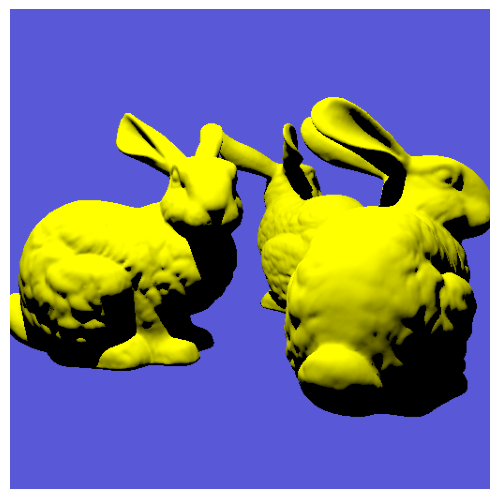

In [9]:
staging = vk.tensor(render_target.height, render_target.width, 4)
render_target.save(staging)
import matplotlib.pyplot as plt
plt.imshow(staging.cpu() ** (1.0/2.2))
plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.show()

Let's do the video!

In [10]:
video_data = vk.tensor(100, SCREEN_HEIGHT, SCREEN_WIDTH, 3)  # 100 frames

In [11]:
for i in range(len(video_data)):
    alpha = i / len(video_data)
    light_pos = vk.vec3(np.cos(alpha * 7), np.sin(alpha) + 4., np.sin(alpha * 7))*(1 + np.sin(alpha)*0.2)
    # we dont need to map because is permanently mapped and update is always CPU -> GPU
    with global_transform as b:
        b.LightPos = light_pos
    vk.submit(man)
    render_target.save(staging)
    video_data[i] = staging[...,:3] ** (1.0/2.2)  # copy current frame to video (only RGB)  


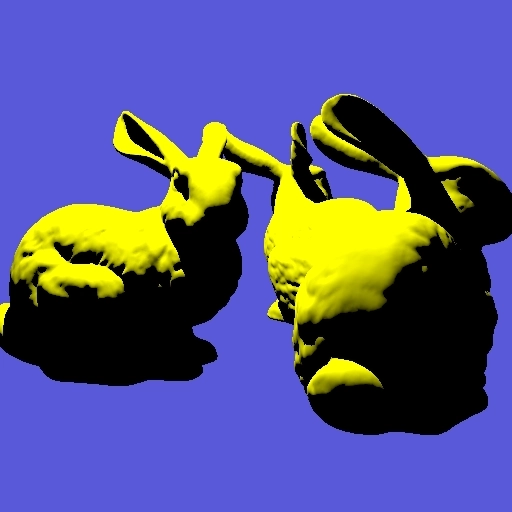

In [12]:
vk.save_video(video_data, 'teaser8.webp', 10, quality=100)
import moviepy.editor
moviepy.editor.ipython_display("teaser8.webp", filetype='image')